# ml4hc - project 2 - embedding classification



## setup

In [1]:
%%capture
#@title set up auto-formatting of cells in notebook

from IPython.display import HTML, display


def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )
get_ipython().events.register("pre_run_cell", set_css)

In [2]:
#@markdown force update relevant packages
!pip install -U numpy pandas matplotlib scikit-learn nltk  -q


In [3]:
#@markdown set up logfile
import logging
logging.basicConfig(
    filename="LOGFILE_ml4hc_project2.log",
    filemode="a",
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
)
# USAGE logging.info("this message will be recorded")

In [4]:
#@markdown check  system stats
from psutil import virtual_memory
import os
ram_gb = round(virtual_memory().total / (1024**3), 1)
logging.info(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')
print(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')

Runtime has 12.7 gigs of memory and 2 processors


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#@markdown import all the things
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation, digits

from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, VarianceThreshold, f_classif)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


import os
from string import punctuation, digits
from os import path

import numpy as np
import pandas as pd

import gensim.models
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors, Word2Vec
from gensim import utils

from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load data and preprocess

### define backup URLS to load data from

In [7]:
#@markdown this cell uses the `bash` shell commands (inside jupyter) to download 
#@markdown the relevant dataset in the dropbown to the runtime. the variable `data_dir`
#@markdown points to the directory containing the files.
url_project2data_full = "https://www.dropbox.com/sh/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca?dl=1" #@param {type:"string"}
url_project2data_20k = "https://www.dropbox.com/sh/tr0jyps0qbqwo9v/AAAdfglvn1RLAza4Y2mtG33Za?dl=1" #@param {type:"string"}
data_dir = "/content/project2-data" #@param {type:"string"}
!rm -r $data_dir # clear out directory 
zip_name = "dataset.zip"
dataset = "full" #@param ["full", "20k"]
if dataset == "20k":
    # download the 20k short dataset
    !wget $url_project2data_20k -O $zip_name
    !unzip -j -q $zip_name -d $data_dir
else:
    # download the full dataset
    !wget $url_project2data_full -O $zip_name
    !unzip -j -q $zip_name -d $data_dir

print("\n" * 3, f"files in the {data_dir} directory are:")
!ls $data_dir

--2022-04-26 20:42:22--  https://www.dropbox.com/sh/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca [following]
--2022-04-26 20:42:23--  https://www.dropbox.com/sh/dl/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc35ed1ceb0de680c12fbe66dd7a.dl.dropboxusercontent.com/zip_download_get/BHh_sFq2_awiBSx_X2Ma9iUTQi62pLvs1lfpArlSHL_OHJk1-jLd7I6_tSg5dLLVo2NABG4Bx7ni-nJIEfyqghGaSNzDTlLnjUZud4ObD0LhNQ?dl=1# [following]
--2022-04-26 20:42:23--  https://uc35ed1ceb0de680c12fbe66dd7a.dl.dropboxusercontent.com/zip_download_get/BHh_sFq2_awiBSx_X2Ma9iUTQi62pLvs1lfpArlSHL_OHJk1-jLd7I6_tSg5dLLVo2NABG4Bx7ni-

### utilities


In [8]:
from datetime import datetime


def get_timestamp():
    """
    get_timestamp - return a timestamp in the format YYYY-MM-DD HH-MM-SS
    """
    return datetime.now().strftime("%b-%d-%Y_%H-%M-%S")

### preprocess function

In [9]:
#@markdown added tqdm to get a progress bar. [tqdm docs](https://tqdm.github.io/)
from tqdm.auto import tqdm 
from pathlib import Path

In [10]:
#Load and preprocess data 
def load_split(filename, preprocess = True, stemmer = False,
               rejoin_post_stem=False):
    with open(filename, "r") as f:
        textlines = f.readlines() # renamed from 'file'
    abstract =""
    abstract_samples = []
    nb_line = 0

    base_name = Path(filename).name  # added tqdm just to show progress (this line and next)
    for sentence in tqdm(
                        textlines, # renamed from 'file'
                        total=len(textlines), 
                        desc=f"processing {base_name}", 
                    ):
        #print(sentence)
        if(sentence[:3] == ("###")):
            abstract_id = sentence
            abstract =""
            nb_line = 0
        #elif(sentence[:2] == ("\n")):
            #abstract_split = abstract.splitlines()
            
        #else:
        elif(sentence[:2] != ("\n")):
            line = {}
            sentence_split = sentence.split("\t")
            
            line["target"] = sentence_split[0]
            line["description"] = sentence_split[1].lower().replace("\n", "")
            line["line_number"] = nb_line 
            nb_line +=1
            
            if(preprocess):
                # split into words
                tokens = word_tokenize(line["description"])
                # remove punctuation from each word
                table = str.maketrans('', '', string.punctuation)
                stripped = [w.translate(table) for w in tokens]
                # remove remaining tokens that are not alphabetic
                words = [word for word in stripped if word.isalpha()]
                # filter out stop words
                stop_words = set(stopwords.words('english'))
                words = [w for w in words if not w.lower() in stop_words]
                line["preprocess"] = words

                if(stemmer):
                  stemmer_ps = PorterStemmer() 
                  stemmed_words_ps = [stemmer_ps.stem(word) for word in words]
                  # NOTE - THIS WAS ADDED. convert the stemmed list back into "normal"
                  line["preprocess"] = " ".join(stemmed_words_ps) if rejoin_post_stem else stemmed_words_ps
            
            abstract_samples.append(line)
            

    return abstract_samples

### clean & process

In [11]:
do_preprocess = False #@param {type:"boolean"}
do_stem = False #@param {type:"boolean"}
rejoin_stemmed = False #@param {type:"boolean"}
preprocess_options = {
    "do_preprocess":do_preprocess,
    "do_stem":do_stem,
    "rejoin_stemmed":rejoin_stemmed,
}
logging.info(f"\n\nsetting preprocessing options to:\n\t{preprocess_options}")
get_timestamp()

'Apr-26-2022_20-42-36'

In [12]:
base_path = data_dir
train_samples_preprocess = load_split(os.path.join(base_path,"train.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)
val_samples_preprocess = load_split(os.path.join(base_path,"dev.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)
test_samples_preprocess = load_split(os.path.join(base_path,"test.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)

processing train.txt:   0%|          | 0/2593169 [00:00<?, ?it/s]

processing dev.txt:   0%|          | 0/33932 [00:00<?, ?it/s]

processing test.txt:   0%|          | 0/34493 [00:00<?, ?it/s]

In [13]:
#Transform in dataframes 
train_df = pd.DataFrame(train_samples_preprocess).convert_dtypes()
val_df = pd.DataFrame(val_samples_preprocess).convert_dtypes()
test_df = pd.DataFrame(test_samples_preprocess).convert_dtypes()
train_df.head(15)

,target,description,line_number
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0
1,BACKGROUND,this paper describes the design and evaluation...,1
2,METHODS,this study is designed as a randomised control...,2
3,METHODS,the intervention group will participate in the...,3
4,METHODS,the program is based on self-efficacy theory a...,4
5,METHODS,participants will access the program for a min...,5
6,METHODS,primary outcomes are domain specific self-effi...,6
7,METHODS,"secondary outcomes include : depression , anxi...",7
8,METHODS,"data collection will take place at baseline , ...",8
9,CONCLUSIONS,results of the positive outlook study will pro...,9


In [14]:
#lists of sentences
train_sentences = train_df['description'].tolist()
val_sentences = val_df['description'].tolist()
test_sentences = test_df['description'].tolist()

print(f"the first value of train is {train_sentences[0]}")


the first value of train is the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .


In [15]:
#lists of preprocessed sentences
if not do_preprocess:
    print(f"preprocessing set to {do_preprocess}, copying description col into preprocess col")
    train_df['preprocess'] = train_df['description']
    val_df['preprocess'] = val_df['description']
    test_df['preprocess'] = test_df['description']
train_sentences_prep = train_df['preprocess'].tolist()
val_sentences_prep = val_df['preprocess'].tolist()
test_sentences_prep = test_df['preprocess'].tolist()

print(f"the first value of train is {train_sentences_prep[0]}")

preprocessing set to False, copying description col into preprocess col
the first value of train is the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .


In [16]:
#lists of targets
labels_train = train_df['target'].tolist()
labels_val = val_df['target'].tolist()
labels_test = test_df['target'].tolist()

In [17]:
label_map = {
    'BACKGROUND': 0,
    'CONCLUSIONS': 1,
    'METHODS': 2,
    'OBJECTIVE': 3,
    'RESULTS': 4,
}

In [18]:
#Encode labels
train_labels = np.asarray([label_map[label] for label in labels_train])
val_labels = np.asarray([label_map[label] for label in labels_val])
test_labels = np.asarray([label_map[label] for label in labels_test])

<AxesSubplot:ylabel='count'>

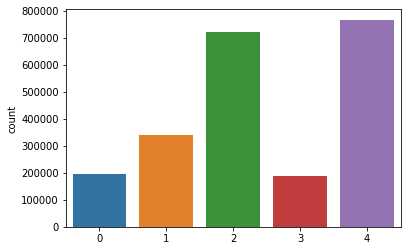

In [19]:
sns.countplot(x=train_labels)

##Save/load preprocessed 

In [ ]:
import csv
path_base = ('drive/MyDrive/ETH')
#train_df['preprocess'].to_csv(os.path.join(path_base,"train_sentences_prep_noStem.csv")) 
#test_df['preprocess'].to_csv(os.path.join(path_base,"test_sentences_prep_noStem.csv")) 
#val_df['preprocess'].to_csv(os.path.join(path_base,"val_sentences_prep_noStem.csv")) 

#train_df['preprocess'].to_csv(os.path.join(path_base,"stemmed_processed_fulldata_TRAIN.csv")) 
#test_df['preprocess'].to_csv(os.path.join(path_base,"stemmed_processed_fulldata_TEST.csv")) 
#val_df['preprocess'].to_csv(os.path.join(path_base,"stemmed_processed_fulldata_VAL.csv")) 

In [20]:
path_base = ('drive/MyDrive/ETH')
train_sentences_prep = pd.read_csv(os.path.join(path_base,"stemmed_processed_fulldata_TRAIN.csv"))['preprocess']
test_sentences_prep = pd.read_csv(os.path.join(path_base,"stemmed_processed_fulldata_TEST.csv"))['preprocess']
val_sentences_prep = pd.read_csv(os.path.join(path_base,"stemmed_processed_fulldata_VAL.csv"))['preprocess']

# Task 1: Baseline Model 

### Classifiers

In [ ]:
# MLP
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(50,), activation='tanh',
                    random_state=1)

In [ ]:
# Logistic Regression
LR = LogisticRegression(
    verbose=0,
    class_weight = "balanced",
    random_state = 0,
    multi_class = "multinomial",
    max_iter=100 ** 2,
    n_jobs=os.cpu_count(),
)

###Pipeline

In [ ]:
# Create a pipeline
baseline = Pipeline([
  ("tf-idf", TfidfVectorizer(lowercase=False, tokenizer=lambda i:i)),
   #TfidfVectorizer(lowercase=False)),
  ("clf", LR)
])

baseline.fit(X=train_sentences_prep, 
            y=train_labels);

In [ ]:
# Evaluate on validation set
val_score = baseline.score(X=test_sentences_prep,
              y=test_labels)
val_score = round(val_score, 4)
logging.info(f"received score of {val_score} on validation with MLP with settings:\n\t{preprocess_options}")
val_score

0.0904

In [ ]:
# Make predictions
y_pred = baseline.predict(test_sentences_prep)
f_score = f1_score(test_labels, y_pred, average="weighted")
f_score = round(f_score, 4)

logging.info(f"received f1_score of {f_score} on test set with with LR settings:\n\t{preprocess_options}")

f_score

0.0152

In [ ]:
#Store predictions 
model_name = 'MLP'
np.save(f"./MLP_test_{model_name}.npy", y_pred, allow_pickle=True)

In [ ]:
#Analyse the confusion matrix 
confusion_matrix(test_labels, y_pred)

array([[1353,  431,  266,  455,  158],
       [ 375, 2916,  242,  146,  747],
       [ 107,  197, 8545,  147,  755],
       [ 474,  210,  345, 1257,   91],
       [  82,  548, 1083,   42, 8521]])

### logfile after Task 1

In [ ]:
!cat /content/LOGFILE_ml4hc_project2.log

# Task 2 : Word Embedding


##Load the models

###Without Stemming

In [ ]:
size = 100
ft_model = FastText.load(os.path.join(path_base,"fasttext100_withoutStemming.model"))
#w2v_model = Word2Vec.load(os.path.join(path_base,"w2vec100.model"))

In [ ]:
size = 10
ft_model = FastText.load(os.path.join(path_base,"fasttext10_withoutStemming.model"))
#w2v_model = Word2Vec.load(os.path.join(path_base,"w2v10_withoutStemming.model"))

###With Stemming

In [21]:
size = 10
ft_model = FastText.load(os.path.join(path_base,"fasttext10_Stem.model"))
#w2v_model = Word2Vec.load(os.path.join(path_base,"w2v10_withoutStemming.model"))

##Run the models

In [62]:
size = 10

In [63]:
ft_model = FastText(sentences = train_sentences_prep,   # list of tokenized sentences
                               workers = 8,                         # Number of threads to run in parallel
                               iter = 5,                       # Number of epochs
                               size = size,                          # Word vector dimensionality     
                               )

In [64]:
ft_model.save(os.path.join(path_base,"fasttext10_Stem.model"))

In [26]:
w2v_model = gensim.models.Word2Vec(sentences = train_sentences_prep,   # list of tokenized sentences
                               workers = 8,                         # Number of threads to run in parallel
                               iter = 5,                       # Number of epochs
                               size = size,                          # Word vector dimensionality     
                               )

##Create the embedding matrices 

###Average sentence embedding  

In [ ]:
def sentence_embedd_average(model,data):
    x = []
    for index in range(len(data)):
        # remove out-of-vocabulary words
        doc = [word for word in data[index] if word in model.wv.vocab.keys()]
        if not doc:
            # append zero vector
            x.append(np.zeros(size))

        else:
            # append the average vector for each sentence
            x.append(np.mean(model[doc], axis=0))
        
    X = np.array(x)

    return X

In [ ]:
Xtrain_av = sentence_embedd_average(ft_model, train_sentences_prep)
Xval_av = sentence_embedd_average(ft_model, val_sentences_prep)
Xtest_av = sentence_embedd_average(ft_model, test_sentences_prep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


###Concatenate sentence embedding

In [ ]:
def sentence_embedd_concatenate(model,data):
    x = []
    maxwords = max([len(train_sentences_prep[i]) for i in range(len(train_sentences_prep))])
    for index in range(len(data)):
        # remove out-of-vocabulary words
        doc = [word for word in data[index] if word in model.wv.vocab.keys()]
        if not doc:
            # append zero vector
            x.append(np.zeros((maxwords,size)))

        else:
            # append the average vector for each sentence
            sentence = np.array(model[doc])
            #x.append(np.array(model[doc], dtype=object))
            #print(len(model[doc]))
            if len(model[doc]) < maxwords:
              sentence = np.append(sentence, np.zeros(((maxwords-len(model[doc])),size)), axis=0)
              #print(len(sentence))
            x.append(np.array(sentence))
            
        
    X = np.array(x)
    return X

In [ ]:
Xtrain_conc = sentence_embedd_concatenate(w2v_model, train_sentences_prep)
Xval_conc = sentence_embedd_concatenate(w2v_model, val_sentences_prep)
Xtest_conc = sentence_embedd_concatenate(w2v_model, test_sentences_prep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
#Reshape 
Xtrain_conc = Xtrain_conc.reshape((Xtrain_conc.shape[0], Xtrain_conc.shape[1]*Xtrain_conc.shape[2]))
Xval_conc = Xval_conc.reshape((Xval_conc.shape[0], Xval_conc.shape[1]*Xval_conc.shape[2]))
Xtest_conc = Xtest_conc.reshape((Xtest_conc.shape[0], Xtest_conc.shape[1]*Xtest_conc.shape[2]))

###One sentence context average embedding

In [22]:
def context1_embedd_average(w2v_model,train_df):
    x = []

    for index in range(len(train_df['preprocess'])):
        # remove out-of-vocabulary words
        #print(index)
        if (index >1) and (index<(len(train_df)-1)):
         # print('here')
          #print(train_df['line_number'][index-1])
          if (train_df['line_number'][index-1] < train_df['line_number'][index]) :
            prev_context = [word for word in train_df['preprocess'][index-1] if word in w2v_model.wv.vocab.keys()]
          else : prev_context=[]

          if (train_df['line_number'][index+1] > train_df['line_number'][index]) :
            next_context = [word for word in train_df['preprocess'][index+1] if word in w2v_model.wv.vocab.keys()]
          else : next_context=[]
        else :
          prev_context=[]
          next_context=[]
        sentence = [word for word in train_df['preprocess'][index] if word in w2v_model.wv.vocab.keys()]
        

        if not prev_context : prev_context= np.zeros(size)
        else : prev_context = np.mean(w2v_model[prev_context], axis=0)

        if not next_context : next_context= np.zeros(size)
        else : next_context = np.mean(w2v_model[next_context], axis=0)

        if not sentence : sentence= np.zeros(size)
        else : sentence = np.mean(w2v_model[sentence], axis=0)       

        doc = [prev_context, sentence, next_context]
            
        x.append(doc)
        
    X = np.array(x)


    return X

In [ ]:
Xtrain_context1 = context1_embedd_average(ft_model, train_df)
Xval_context1 = context1_embedd_average(ft_model, val_df)
Xtest_context1 = context1_embedd_average(ft_model, test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
#Reshape 
Xtrain_context1 = Xtrain_context1.reshape((Xtrain_context1.shape[0], Xtrain_context1.shape[1]*Xtrain_context1.shape[2]))
Xval_context1 = Xval_context1.reshape((Xval_context1.shape[0], Xval_context1.shape[1]*Xval_context1.shape[2]))
Xtest_context1 = Xtest_context1.reshape((Xtest_context1.shape[0], Xtest_context1.shape[1]*Xtest_context1.shape[2]))

###Two sentences context average embedding

In [34]:
def context2_embedd_average(w2v_model,train_df):
    x = []

    for index in range(len(train_df['preprocess'])):
        # remove out-of-vocabulary words
        #print(index)
        if (index >1) and (index<(len(train_df)-1)):
          if (train_df['line_number'][index-1] < train_df['line_number'][index]) :
            prev_context1 = [word for word in train_df['preprocess'][index-1] if word in w2v_model.wv.vocab.keys()]
          else : prev_context1=[]

          if (train_df['line_number'][index+1] > train_df['line_number'][index]) :
            next_context1 = [word for word in train_df['preprocess'][index+1] if word in w2v_model.wv.vocab.keys()]
          else : next_context1=[]

        if (index >2) and (index<(len(train_df)-2)):
          if (train_df['line_number'][index-2] < train_df['line_number'][index]) :
            prev_context2 = [word for word in train_df['preprocess'][index-2] if word in w2v_model.wv.vocab.keys()]
          else : prev_context2=[]
          if (train_df['line_number'][index+2] < train_df['line_number'][index]) :
            next_context2 = [word for word in train_df['preprocess'][index+2] if word in w2v_model.wv.vocab.keys()]
          else : next_context2=[]

          
        else :
          prev_context1=[]
          next_context1=[]
          prev_context2=[]
          next_context2=[]

        sentence = [word for word in train_df['preprocess'][index] if word in w2v_model.wv.vocab.keys()]
        

        if not prev_context1 : prev_context1= np.zeros(size)
        else : prev_context1 = np.mean(w2v_model[prev_context1], axis=0)

        if not next_context1 : next_context1= np.zeros(size)
        else : next_context1 = np.mean(w2v_model[next_context1], axis=0)

        if not prev_context2 : prev_context2= np.zeros(size)
        else : prev_context2 = np.mean(w2v_model[prev_context2], axis=0)

        if not next_context2 : next_context2= np.zeros(size)
        else : next_context2 = np.mean(w2v_model[next_context2], axis=0)

        if not sentence : sentence= np.zeros(size)
        else : sentence = np.mean(w2v_model[sentence], axis=0)       

        doc = [prev_context2, prev_context1, sentence, next_context1, next_context2]
            
        x.append(doc)
        
    X = np.array(x)


    return X

In [35]:
Xtrain_context2 = context2_embedd_average(w2v_model, train_df)
Xval_context2 = context2_embedd_average(w2v_model, val_df)
Xtest_context2 = context2_embedd_average(w2v_model, test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [36]:
#Reshape 
Xtrain_context2 = Xtrain_context2.reshape((Xtrain_context2.shape[0], Xtrain_context2.shape[1]*Xtrain_context2.shape[2]))
Xval_context2 = Xval_context2.reshape((Xval_context2.shape[0], Xval_context2.shape[1]*Xval_context2.shape[2]))
Xtest_context2 = Xtest_context2.reshape((Xtest_context2.shape[0], Xtest_context2.shape[1]*Xtest_context2.shape[2]))

## Classifier

In [37]:
lr = LogisticRegression(max_iter=1000)
lr.fit(Xtrain_context1, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=1000)

In [38]:
# Make predictions
y_preds = lr.predict(Xtest_context1)
f1 = f1_score(test_labels, y_preds, average='weighted')
print('LogReg f1 score weighted : {}',f1)


LogReg f1 score weighted : {} 0.6903423182978591
